<a href="https://colab.research.google.com/github/dguari1/Data_Science_Biomechanics/blob/main/movementinPD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# access disc
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#install mediapipe for pose estimation 
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 38.6 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 23.1.4 which is incompatible.


In [4]:
# import libraries
import numpy as np
import cv2
import mediapipe as mp 
import matplotlib.pyplot as plt

In [5]:
#load pose detector and drawing utilities
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

#create pose detector object
pose = mp_pose.Pose(min_detection_confidence=0.5,min_tracking_confidence=0.5)

In [6]:


#load video #video is at 30 fps, avaliable in youtube at 
# https://www.youtube.com/watch?v=t1IkEAkBSz4&list=PLwlvPe1bGTl8bpoazSfl9LBxrRC16-LkA&index=8
# you can download the video using any different websites (search for - youtube video download-)

video = cv2.VideoCapture('/content/gdrive/MyDrive/PDVideo/pd_walk.mp4')



In [7]:
# check video properties 
width = video.get(cv2.CAP_PROP_FRAME_WIDTH)
height = video.get(cv2.CAP_PROP_FRAME_HEIGHT)
fps = video.get(cv2.CAP_PROP_FPS)
numFrames = video.get(cv2.CAP_PROP_FRAME_COUNT)
videoDuration = numFrames/fps

print(f'FPS = {fps} frames/second \nNumber of Frames = {numFrames} frames \nVideo Duration = {videoDuration} s \nVideo Width = {width} pixels \nVideo Height = {height} pixels')

FPS = 30.0 frames/second 
Number of Frames = 6768.0 frames 
Video Duration = 225.6 s 
Video Width = 644.0 pixels 
Video Height = 480.0 pixels


In [8]:
# select the sections of the video that you are interested

#OFF med Starts = 2:19:971
#OFF med Ends = 2:22:821
medOFFFrames = [139.971*fps, 142.821*fps]
#ON med Starts = 2:30:471
#ON med Ends = 2:33:371
medONFrames = [150.471*fps, 153.371*fps]


In [9]:
#move video to desired frame position
video.set(cv2.CAP_PROP_POS_FRAMES, medOFFFrames[0]); 
#read frame 
state, videoFrame = video.read()

print(f'Frame Read = {state}')

Frame Read = True


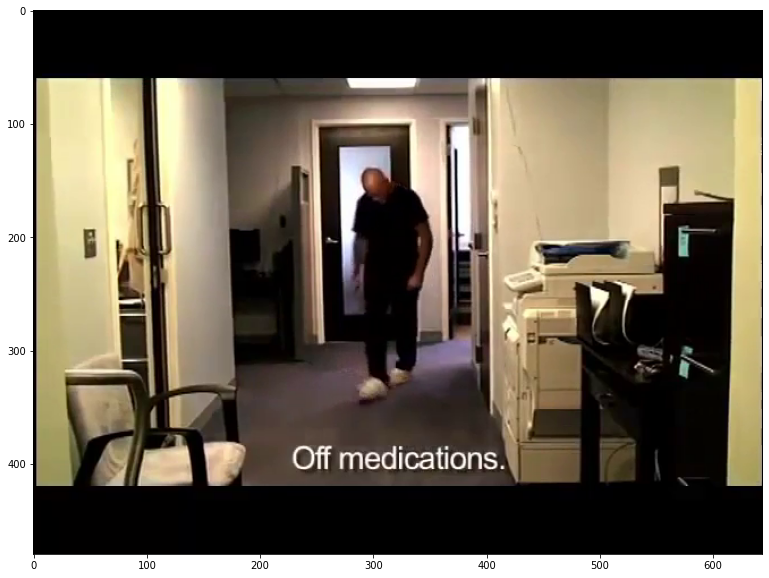

In [10]:
#show frame 
image = cv2.cvtColor(videoFrame, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(image)

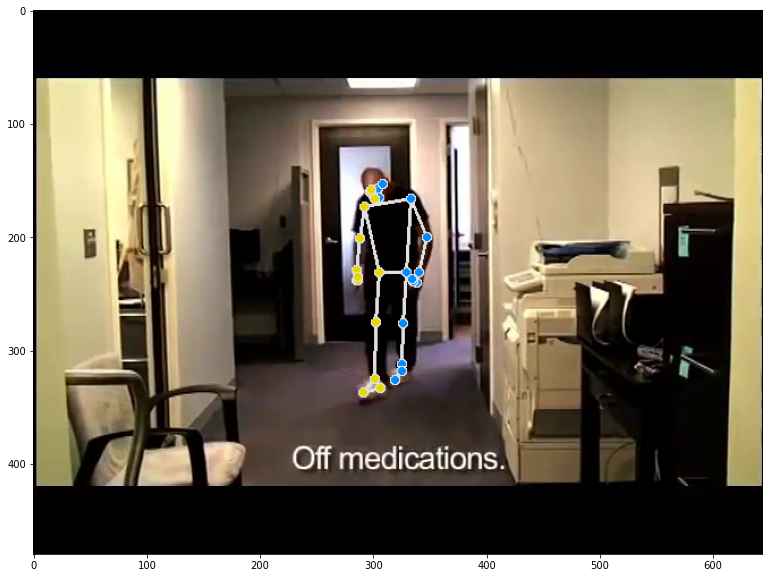

In [11]:
#detect pose 
results = pose.process(image)

#draw results 
mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(image)

In [ ]:
# what are the results ?
results.pose_world_landmarks

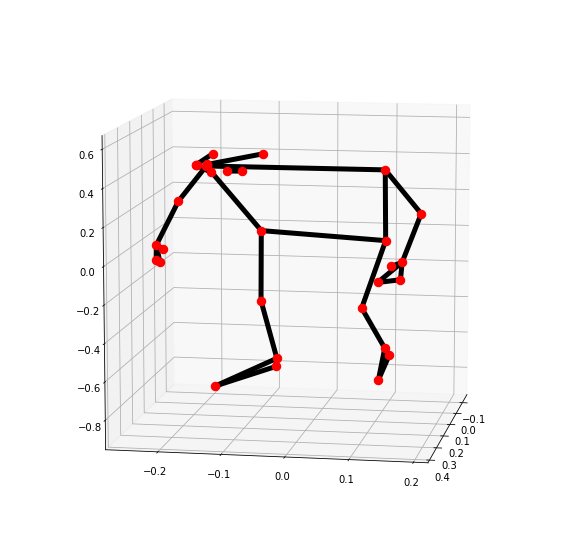

In [13]:
#plot landmarks only
mp_drawing.plot_landmarks(
        results.pose_world_landmarks,  mp_pose.POSE_CONNECTIONS)

![link text](https://mediapipe.dev/images/mobile/pose_tracking_full_body_landmarks.png)

In [26]:
#analysis OFF segment 

#move video to desired frame position
video.set(cv2.CAP_PROP_POS_FRAMES, medOFFFrames[0]); 
#read frame 
numFramestoReadOFF = medOFFFrames[1]-medOFFFrames[0]
leftArmMovementOFF = np.zeros(int(numFramestoReadOFF))
rightArmMovementOFF = np.zeros(int(numFramestoReadOFF))
for i in range(int(numFramestoReadOFF)):
  state, videoFrame = video.read()
  image = cv2.cvtColor(videoFrame, cv2.COLOR_BGR2RGB)
  results = pose.process(image)

  #landmarks 3d position
  landmarks = results.pose_world_landmarks.landmark
  leftElbowShoulder = np.array([landmarks[13].x, landmarks[13].y, landmarks[13].z]) - np.array([landmarks[11].x, landmarks[11].y, landmarks[11].z])
  leftElbowWrist = np.array([landmarks[13].x, landmarks[13].y, landmarks[13].z]) - np.array([landmarks[15].x, landmarks[15].y, landmarks[15].z])
  #leftElbow = np.array([landmarks[13].x, landmarks[13].y, landmarks[13].z])

  rightElbowShoulder = np.array([landmarks[14].x, landmarks[14].y, landmarks[14].z]) - np.array([landmarks[12].x, landmarks[12].y, landmarks[12].z])
  rightElbowWrist = np.array([landmarks[14].x, landmarks[14].y, landmarks[14].z]) - np.array([landmarks[16].x, landmarks[16].y, landmarks[16].z])
  # rightElbow = np.array([landmarks[16].x, landmarks[16].y, landmarks[16].z])




  leftArmMovementOFF[i] = np.arccos(np.dot(leftElbowShoulder, leftElbowWrist) / (np.linalg.norm(leftElbowShoulder) * np.linalg.norm(leftElbowWrist))) #np.linalg.norm(leftShoulder - leftWrist)
  rightArmMovementOFF[i] = np.arccos(np.dot(rightElbowShoulder, rightElbowWrist) / (np.linalg.norm(rightElbowShoulder) * np.linalg.norm(rightElbowWrist)))#np.linalg.norm(rightShoulder - rightWrist)


(2.0, 3.0)

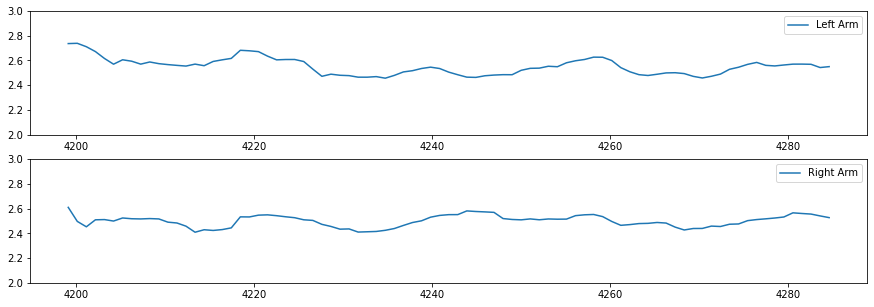

In [28]:
#plot results
fig, ax = plt.subplots(2,1,figsize=(15, 5))
ax[0].plot(np.linspace(medOFFFrames[0],medOFFFrames[1],int(numFramestoReadOFF)), leftArmMovementOFF, label='Left Arm')
ax[0].set_ylim([2,3])
ax[0].legend()
ax[1].plot(np.linspace(medOFFFrames[0],medOFFFrames[1],int(numFramestoReadOFF)), rightArmMovementOFF, label='Right Arm')
ax[1].legend()
ax[1].set_ylim([2,3])

In [30]:
#analysis ON segment 

#move video to desired frame position
video.set(cv2.CAP_PROP_POS_FRAMES, medONFrames[0]); 
#read frame 
numFramestoReadON = medONFrames[1]-medONFrames[0]
leftArmMovementON = np.zeros(int(numFramestoReadON))
rightArmMovementON = np.zeros(int(numFramestoReadON))
for i in range(int(numFramestoReadON)):
  state, videoFrame = video.read()
  image = cv2.cvtColor(videoFrame, cv2.COLOR_BGR2RGB)
  results = pose.process(image)

  #landmarks 3d position
  landmarks = results.pose_world_landmarks.landmark
  leftElbowShoulder = np.array([landmarks[13].x, landmarks[13].y, landmarks[13].z]) - np.array([landmarks[11].x, landmarks[11].y, landmarks[11].z])
  leftElbowWrist = np.array([landmarks[13].x, landmarks[13].y, landmarks[13].z]) - np.array([landmarks[15].x, landmarks[15].y, landmarks[15].z])
  #leftElbow = np.array([landmarks[13].x, landmarks[13].y, landmarks[13].z])

  rightElbowShoulder = np.array([landmarks[14].x, landmarks[14].y, landmarks[14].z]) - np.array([landmarks[12].x, landmarks[12].y, landmarks[12].z])
  rightElbowWrist = np.array([landmarks[14].x, landmarks[14].y, landmarks[14].z]) - np.array([landmarks[16].x, landmarks[16].y, landmarks[16].z])
  # rightElbow = np.array([landmarks[16].x, landmarks[16].y, landmarks[16].z])


  leftArmMovementON[i] = np.arccos(np.dot(leftElbowShoulder, leftElbowWrist) / (np.linalg.norm(leftElbowShoulder) * np.linalg.norm(leftElbowWrist))) #np.linalg.norm(leftShoulder - leftWrist)
  rightArmMovementON[i] = np.arccos(np.dot(rightElbowShoulder, rightElbowWrist) / (np.linalg.norm(rightElbowShoulder) * np.linalg.norm(rightElbowWrist)))#np.linalg.norm(rightShoulder - rightWrist)

(2.0, 3.0)

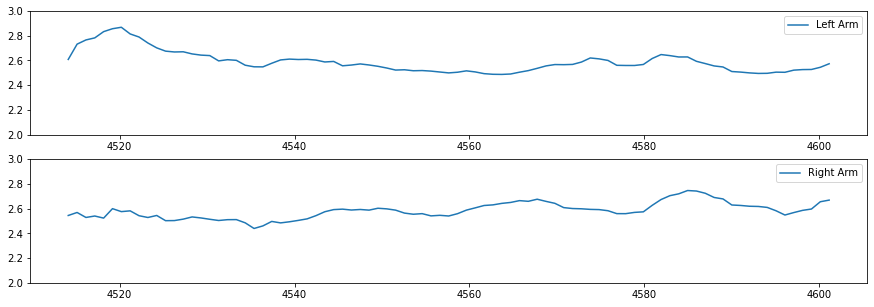

In [32]:
#plot results
fig, ax = plt.subplots(2,1,figsize=(15, 5))
ax[0].plot(np.linspace(medONFrames[0],medONFrames[1],int(numFramestoReadON)), leftArmMovementON, label='Left Arm')
ax[0].set_ylim([2,3])
ax[0].legend()
ax[1].plot(np.linspace(medONFrames[0],medONFrames[1],int(numFramestoReadON)), rightArmMovementON, label='Right Arm')
ax[1].legend()
ax[1].set_ylim([2,3])

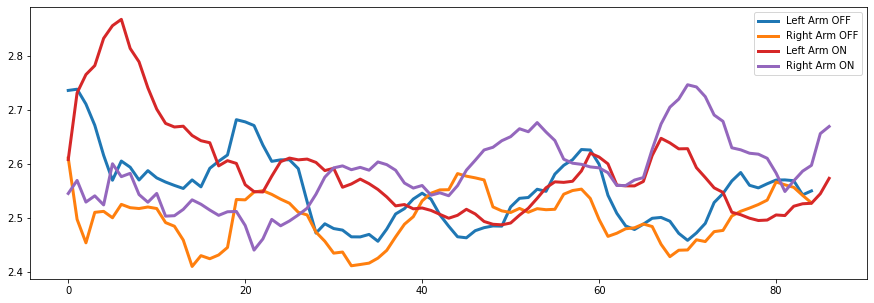

In [33]:
#all the signals together

#plot results
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(leftArmMovementOFF, 'tab:blue', lw= 3, label='Left Arm OFF')

ax.plot(rightArmMovementOFF,'tab:orange', lw= 3,  label='Right Arm OFF')

ax.plot(leftArmMovementON, 'tab:red', lw= 3, label='Left Arm ON')
ax.plot(rightArmMovementON, 'tab:purple', lw= 3, label='Right Arm ON')
ax.legend()

In [36]:
print(f'OFF -> Left Arm Variability = {np.std(leftArmMovementOFF)} | Rigth Arm Varibility = {np.std(rightArmMovementOFF)} \n ON -> Left Arm Variability = {np.std(leftArmMovementON)} | Rigth Arm Varibility = {np.std(rightArmMovementON)} ' )

OFF -> Left Arm Variability = 0.06617021269038352 | Rigth Arm Varibility = 0.04622062159603521 
 ON -> Left Arm Variability = 0.08773641002652255 | Rigth Arm Varibility = 0.063969827797769 
